In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
save_numpy_dataloaders=True

# GENERAL VISUALIZER

# IMPORT LIBRARIES

In [3]:
import os
import nibabel as nib
import numpy as np
import torchvision
from scipy.ndimage import zoom
import numpy as np
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
import re
import os
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageEnhance
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

# GENERAL FUNCTIONS

In [4]:

def resize_image(image, new_shape):
    """
    Cambia el tamaño de una imagen al nuevo shape especificado.
    """
    return resize(image, new_shape, anti_aliasing=True)

def load_and_resize_images(directory, shapes, file_type):
    """
    Carga todos los archivos .npy en el directorio especificado, los concatena y redimensiona.
    Solo carga archivos que corresponden al tipo especificado ('images' o 'labels').
    """
    original_images = []
    resized_images_128 = []

    # Cargar los archivos .npy y concatenarlos
    for i in range(6):  # Para los archivos ordenados de 0 a 3
        file_name = f"{file_type}_batch_{i}.npy"
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            batch = np.load(file_path)

            # Aplanar las imágenes de cada batch y agregarlas a las listas
            for image in tqdm(batch):
                original_images.append(image)
                resized_images_128.append(resize_image(image, shapes[0]))

    return np.array(original_images), np.array(resized_images_128)

In [5]:
def prepare_dataloaders(images, images_128, batch_size=128, test_size=0.2, validation_size=0.5):
    """
    Prepara dataloaders para entrenamiento, prueba y validación.

    Args:
    images (numpy array): Imágenes de alta resolución.
    images_128 (numpy array): Imágenes de baja resolución.
    batch_size (int): Tamaño del batch.
    test_size (float): Porcentaje del dataset para el conjunto de prueba.
    validation_size (float): Porcentaje del conjunto de prueba para la validación.
    """
    ref_ct=images[:252]
    images_tensor = images[252:]
    images_128_tensor = images_128[252:]
    # Convertir a tensores y normalizar
    images_tensor = torch.tensor(images_tensor).float() / 255.0
    images_128_tensor = torch.tensor(images_128_tensor).float() / 255.0
    # Cambiar de forma para que sean compatibles con el modelo (B, C, H, W)
    images_tensor = images_tensor.unsqueeze(1)
    images_128_tensor = images_128_tensor.unsqueeze(1)

    # Dividir en conjuntos de entrenamiento y prueba
    train_x, test_x, train_y, test_y = train_test_split(images_128_tensor, images_tensor, test_size=test_size, random_state=42)

    # Dividir el conjunto de prueba en prueba y validación
    test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=validation_size, random_state=42)

    # Crear datasets
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    val_dataset = TensorDataset(val_x, val_y)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader,ref_ct



In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None, early_stopping_patience=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = 'best_model.pth'  # Define la ruta para guardar el mejor modelo

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        for low_res, high_res in train_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # Validación
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for low_res, high_res in val_loader:
                low_res = low_res.to(device)
                high_res = high_res.to(device)

                outputs = model(low_res)
                loss = criterion(outputs, high_res)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

        # Actualizar el programador de tasa de aprendizaje
        if scheduler:
            scheduler.step(avg_val_loss)

        # Checkpoint para el mejor modelo
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)  # Guarda el estado del modelo
            print(f"Mejor modelo guardado con pérdida de validación: {best_val_loss}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print("Detención temprana!")
                break

    # Cargar el mejor modelo después del entrenamiento
    model.load_state_dict(torch.load(best_model_path))
    return model


In [7]:
def adjust_contrast(image):
    """Ajusta el contraste de una imagen mediante el ecualizado del histograma."""
    # Ecualizar el histograma de la imagen
    adjusted_img = exposure.equalize_adapthist(image, clip_limit=0.03)
    return adjusted_img
def test_model_and_plot_random(model, test_loader, device):
    """
    Evalúa el modelo en el conjunto de prueba, calcula las métricas SSIM y PSNR y muestra
    un plot aleatorio con la imagen original, la imagen de baja resolución y la predicha.
    """
    model.eval()
    ssim_total = 0
    psnr_total = 0
    num_samples = 0

    random_image_selected = False
    random_index = random.randint(0, len(test_loader.dataset) - 1)

    with torch.no_grad():
        for i, (low_res, high_res) in enumerate(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            outputs = model(low_res)

            for j in range(outputs.size(0)):
                predicted = outputs[j].squeeze().cpu().numpy()
                original = high_res[j].squeeze().cpu().numpy()
                low_res_img = low_res[j].squeeze().cpu().numpy()

                ssim_total += ssim(original, predicted, data_range=predicted.max() - predicted.min())
                psnr_total += psnr(original, predicted, data_range=predicted.max() - predicted.min())

                if i * test_loader.batch_size + j == random_index:
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(low_res_img, cmap='gray')
                    plt.title("Low Resolution")
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(predicted, cmap='gray')
                    plt.title("Predicted")
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(original, cmap='gray')
                    plt.title("Ground Truth")
                    plt.axis('off')

                    plt.show()

                    random_image_selected = True

            num_samples += outputs.size(0)
            if random_image_selected:
                break

    avg_ssim = ssim_total / num_samples
    avg_psnr = psnr_total / num_samples

    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

 # DATA LOAD


In [8]:
# Usamos la función para cargar y redimensionar las imágenes
path = '/content/drive/MyDrive/TFM'  # El directorio con los archivos .npy
shapes = [(64, 64)]
images, images_128,= load_and_resize_images(path, shapes,'images')
# labels, labels_128 = load_and_resize_images(path, shapes,'labels')
# Preparar el dataloader
# labels=labels.round()


  0%|          | 0/2866 [00:00<?, ?it/s]

  0%|          | 0/2183 [00:00<?, ?it/s]

  0%|          | 0/2516 [00:00<?, ?it/s]

  0%|          | 0/2683 [00:00<?, ?it/s]

  0%|          | 0/1864 [00:00<?, ?it/s]

  0%|          | 0/2271 [00:00<?, ?it/s]

In [9]:
print("preparing dataloader....")
# Ejemplo de uso
train_loader, test_loader, val_loader,ref_ct = prepare_dataloaders(images, images_128, batch_size=16)
# Convertir a tensores y normalizar
ref_ct = torch.tensor(ref_ct).float() / 255.0

ref_ct = ref_ct.unsqueeze(1)
print(" dataloader created")

preparing dataloader....
 dataloader created


#  MODELS

## EDSR

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)  # Batch Normalization after Conv2

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + residual
        return x

class Upsampling(nn.Module):
    def __init__(self, num_filters, scale_factor):
        super(Upsampling, self).__init__()
        self.conv = nn.Conv2d(num_filters, num_filters * (scale_factor ** 2), kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters * (scale_factor ** 2))  # Batch Normalization
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.bn(self.conv(x))
        x = self.pixel_shuffle(x)
        return x

class EDSRModel(nn.Module):
    def __init__(self, num_filters, num_of_residual_blocks, scale_factor):
        super(EDSRModel, self).__init__()
        self.first_conv = nn.Conv2d(1, num_filters, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(
            *[ResBlock(num_filters) for _ in range(num_of_residual_blocks)]
        )
        self.second_conv = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)  # Batch Normalization
        self.upsampling = Upsampling(num_filters, scale_factor)
        self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.first_conv(x)
        residual = x
        x = self.res_blocks(x)
        x = self.bn(self.second_conv(x))
        x = x + residual
        x = self.upsampling(x)
        x = self.final_conv(x)
        return x

## MODIFIED SRCNN

In [11]:
class ModifiedSRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        super(ModifiedSRCNN, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bicubic')
        self.conv1 = nn.Conv2d(64, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Capa convolucional inicial
        initial_features = self.relu(self.initial_conv(x))

        # Combinar las características iniciales con la imagen de entrada
        combined_features = initial_features + x

        # Upsampling y procesamiento adicional
        upsampled = self.upsample(combined_features)
        x1 = self.relu(self.conv1(upsampled))
        x2 = self.relu(self.conv2(x1))
        x3 = self.conv3(x2)
        return x3

## ResNet

In [12]:
class ResidualBlockDense(nn.Module):
    def __init__(self):
        super(ResidualBlockDense, self).__init__()
        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Cambiado de 1 a 64 en los canales de entrada
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)  # Cambiado de 1 a 64 en los canales de salida
        self.bn2 = nn.BatchNorm2d(64)  # Cambiado de 1 a 64 en BatchNorm

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class SRResNetDense(nn.Module):
    def __init__(self):
        super(SRResNetDense, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.residual_blocks = self.make_layers(ResidualBlockDense, 4)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Cambiado de 1 a 64 en los canales de entrada
        self.bn = nn.BatchNorm2d(64)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )
        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, padding=4)

    def make_layers(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        residual = out
        out = self.residual_blocks(out)
        out = self.bn(self.conv2(out))
        out += residual
        out = self.upsample(out)
        out = self.conv3(out)
        return out

## SIMPLE SRCNN

In [13]:
class SRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        super(SRCNN, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bicubic')
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## SRCNNSE

In [14]:

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Updated SRCNN model with attention
class SRCNNSE (nn.Module):
    def __init__(self):
        super(SRCNNSE, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic')
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.se1 = SEBlock(64)  # Attention after first conv layer
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bicubic')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.se2 = SEBlock(32)  # Attention after second conv layer
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.se1(x)  # Apply attention
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.se2(x)  # Apply attention
        x = self.relu(x)
        x = self.conv3(x)
        return x


## RCAN

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(1, 1, kernel_size=1)
        std = torch.tensor(rgb_std)
        self.weight.data = torch.eye(1).view(1, 1, 1, 1)
        self.weight.data.div_(std)
        self.bias.data = sign * rgb_range * torch.tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlockCAN(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlockCAN, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)
# Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

# Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1):
        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn:
                modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0:
                modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

# Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = [RCAB(conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

class RCAN(nn.Module):
    def __init__(self, conv=default_conv):
        super(RCAN, self).__init__()

        # Definir valores predeterminados
        n_resgroups = 8
        n_resblocks = 8
        n_feats = 64
        kernel_size = 3
        reduction = 4    # Por ejemplo, 16
        scale = 4         # Para cambiar de (1, 64, 64) a (1, 256, 256)
        n_colors = 1
        res_scale = 1

        act = nn.ReLU(True)

        # Eliminar RGB mean y std para escala de grises
        self.sub_mean = MeanShift(255, (0.0,), (1.0,))  # Asumiendo un rango RGB de 255

        # Definir módulo de cabeza
        modules_head = [conv(n_colors, n_feats, kernel_size)]

        # Definir módulo de cuerpo
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]
        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # Definir módulo de cola
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)]

        self.add_mean = MeanShift(255, (0.0,), (1.0,), 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x



## SWINIR

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=1,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops


## mhmM-AT


## texture super resolution

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
def edge_detection_filter():
    return torch.tensor([[[[-1., -1., -1.],
                           [-1.,  8., -1.],
                           [-1., -1., -1.]]]], dtype=torch.float32)

def contrast_increase_filter():
    return torch.tensor([[[[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]]]], dtype=torch.float32)

def batch_mse_loss(img1, img2):
    # Asumiendo que img1 es [N, C, H, W] y img2 es [M, C, H, W]
    # Extiende img1 a [N, M, C, H, W] y img2 a [N, M, C, H, W] para broadcasting
    img1_ext = img1.unsqueeze(1).expand(-1, img2.size(0), -1, -1, -1)
    img2_ext = img2.unsqueeze(0).expand(img1.size(0), -1, -1, -1, -1)
    mse = ((img1_ext - img2_ext) ** 2).mean(dim=(2, 3, 4))
    return mse

def batch_psnr(mse, data_range=1.0):
    # Asegúrate de que data_range sea un tensor y esté en el mismo dispositivo que mse
    data_range_tensor = torch.tensor(data_range).to(mse.device)

    # Evita el logaritmo de cero calculando el máximo entre mse y un pequeño valor epsilon
    mse = torch.clamp(mse, min=1e-10)

    # Asegúrate de que todas las operaciones se realizan con tensores
    psnr = 20 * torch.log10(data_range_tensor) - 10 * torch.log10(mse)
    return psnr

class VariedKernelSizeAttentionHead(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(VariedKernelSizeAttentionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.sigmoid(x)
class feature_extractor(nn.Module):
      def __init__(self, in_channels, out_channels, kernel_size):
        super(feature_extractor, self).__init__()

class MultiModalMultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads, kernel_sizes):
        super(MultiModalMultiHeadAttention, self).__init__()
        self.heads = heads
        self.kernel_sizes = kernel_sizes
        self.in_channels = in_channels
        self.out_channels = in_channels  # Asegurar que los canales de salida coincidan con los de entrada
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, self.out_channels, kernel_size=ks, padding=ks // 2),
                nn.Sigmoid()
            ) for ks in kernel_sizes for _ in range(heads // len(kernel_sizes))
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps, dim=0), dim=0)
        return x * attention
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        reduction_ratio = 16
        reduced_channels = max(num_channels // reduction_ratio, 1)

        self.fc = nn.Sequential(
            nn.Linear(num_channels, reduced_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pooled = self.avg_pool(x).view(x.size(0), -1)
        max_pooled = self.max_pool(x).view(x.size(0), -1)
        avg_out = self.fc(avg_pooled)
        max_out = self.fc(max_pooled)
        out = avg_out + max_out
        return x * out.view(x.size(0), x.size(1), 1, 1)



# Ejemplo de cómo integrar en la SuperResolutionNetwork
class SuperResolutionNetworkExtended_v1(nn.Module):
    def __init__(self, ct_ref_normal, ct_ref_downsampled, scale_factor):
        super(SuperResolutionNetworkExtended_v1, self).__init__()
        # Guarda los CTs de referencia directamente
        self.ct_ref_normal = ct_ref_normal
        # Realiza el downsample del segundo CT basado en el factor de escala
        self.ct_ref_downsampled = ct_ref_downsampled
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)


        self.features = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.features_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv1x1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1, padding=0)
        self.conv1x1_2 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1, padding=0)

        self.attention = MultiModalMultiHeadAttention(in_channels=64, heads=6, kernel_sizes=[3, 5, 7])
        self.attention_1 = MultiModalMultiHeadAttention(in_channels=32, heads=4, kernel_sizes=[3, 5, 7])
        self.attention_2 = MultiModalMultiHeadAttention(in_channels=32, heads=4, kernel_sizes=[3, 5, 7])

        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.upscale_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.output =nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 1, kernel_size=3, padding=1))
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.channel_attention_1 = ChannelAttentionModule(num_channels=32)
        self.channel_attention_2 = ChannelAttentionModule(num_channels=32)  # Ajusta según el número de canales después de la concatenación

    def forward(self, x):

        # Calcula el MSE en batch
        mse_values = batch_mse_loss(x, self.ct_ref_downsampled)
        psnr_values = batch_psnr(mse_values, data_range=1.0)  # Ajusta data_range según tus datos

        # Identifica las imágenes más similares basadas en el mayor PSNR
        most_similar_indices = psnr_values.argmax(dim=1)
        selected_images = self.ct_ref_normal[most_similar_indices]



        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)
        features = self.features(concatenated)
        features = self.features_2(features)
        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)

        upscaled=torch.cat((self.maxpool(self.conv1x1(selected_images)), upscaled), 1)
        attention_applied = self.attention_2(upscaled)
        channel_attended = self.channel_attention_1(upscaled)

        upscaled = self.upscale_2(torch.cat((attention_applied,channel_attended),1))
        upscaled=torch.cat((self.conv1x1_2(selected_images), upscaled), 1)
        out_1=self.attention_1(upscaled)
        out_2 = self.channel_attention_2(upscaled)
        out = self.output(torch.cat((out_1,out_2),1))

        return out

ref_ct_down=F.interpolate(ref_ct,
                                                scale_factor=1/4,
                                                mode='bilinear',
                                                align_corners=False)
scale_factor = 4  # Ejemplo de factor de escala

# Creación del modelo con CTs de referencia
model = SuperResolutionNetworkExtended_v1(ref_ct, ref_ct_down, scale_factor)

input_image = torch.rand(16, 1, 64, 64) # Ejemplo de imagen de entrada
output = model(input_image)

print("Tamaño de la salida:", output.size())

Tamaño de la salida: torch.Size([16, 1, 256, 256])


## new

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
def edge_detection_filter():
    return torch.tensor([[[[-1., -1., -1.],
                           [-1.,  8., -1.],
                           [-1., -1., -1.]]]], dtype=torch.float32)

def contrast_increase_filter():
    return torch.tensor([[[[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]]]], dtype=torch.float32)

def batch_mse_loss(img1, img2):
    # Asumiendo que img1 es [N, C, H, W] y img2 es [M, C, H, W]
    # Extiende img1 a [N, M, C, H, W] y img2 a [N, M, C, H, W] para broadcasting
    img1_ext = img1.unsqueeze(1).expand(-1, img2.size(0), -1, -1, -1)
    img2_ext = img2.unsqueeze(0).expand(img1.size(0), -1, -1, -1, -1)
    mse = ((img1_ext - img2_ext) ** 2).mean(dim=(2, 3, 4))
    return mse

def batch_psnr(mse, data_range=1.0):
    # Asegúrate de que data_range sea un tensor y esté en el mismo dispositivo que mse
    data_range_tensor = torch.tensor(data_range).to(mse.device)

    # Evita el logaritmo de cero calculando el máximo entre mse y un pequeño valor epsilon
    mse = torch.clamp(mse, min=1e-10)

    # Asegúrate de que todas las operaciones se realizan con tensores
    psnr = 20 * torch.log10(data_range_tensor) - 10 * torch.log10(mse)
    return psnr

class VariedKernelSizeAttentionHead(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(VariedKernelSizeAttentionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.sigmoid(x)
class feature_extractor(nn.Module):
      def __init__(self, in_channels, out_channels, kernel_size):
        super(feature_extractor, self).__init__()

class MultiModalMultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads, kernel_sizes):
        super(MultiModalMultiHeadAttention, self).__init__()
        self.heads = heads
        self.kernel_sizes = kernel_sizes
        self.in_channels = in_channels
        self.out_channels = in_channels  # Asegurar que los canales de salida coincidan con los de entrada
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, self.out_channels, kernel_size=ks, padding=ks // 2),
                nn.Sigmoid()
            ) for ks in kernel_sizes for _ in range(heads // len(kernel_sizes))
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps, dim=0), dim=0)
        return x * attention
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        reduction_ratio = 16
        reduced_channels = max(num_channels // reduction_ratio, 1)

        self.fc = nn.Sequential(
            nn.Linear(num_channels, reduced_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pooled = self.avg_pool(x).view(x.size(0), -1)
        max_pooled = self.max_pool(x).view(x.size(0), -1)
        avg_out = self.fc(avg_pooled)
        max_out = self.fc(max_pooled)
        out = avg_out + max_out
        return x * out.view(x.size(0), x.size(1), 1, 1)



# Ejemplo de cómo integrar en la SuperResolutionNetwork
class SuperResolutionNetworkExtended_V2(nn.Module):
    def __init__(self, ct_ref_normal, ct_ref_downsampled, scale_factor):
        super(SuperResolutionNetworkExtended_V2, self).__init__()
        # Guarda los CTs de referencia directamente
        self.ct_ref_normal = ct_ref_normal
        # Realiza el downsample del segundo CT basado en el factor de escala
        self.ct_ref_downsampled = ct_ref_downsampled
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)


        self.features = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.features_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.features_low_1= nn.Conv2d(1,128,kernel_size=2)
        self.features_low_2= nn.Conv2d(128,1,kernel_size=2)
        self.features_low_1_r= nn.Conv2d(1,128,kernel_size=2)
        self.features_low_2_r= nn.Conv2d(128,1,kernel_size=2)
        self.conv1x1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv1x1_2 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1, padding=0)

        self.attention = MultiModalMultiHeadAttention(in_channels=64, heads=6, kernel_sizes=[3, 5, 7])
        self.attention_1 = MultiModalMultiHeadAttention(in_channels=32, heads=4, kernel_sizes=[3, 5, 7])
        self.attention_2 = MultiModalMultiHeadAttention(in_channels=64, heads=4, kernel_sizes=[3, 5, 7])

        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 48, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.upscale_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.output =nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 1, kernel_size=3, padding=1))
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.channel_attention = ChannelAttentionModule(num_channels=64)  # Ajusta según el número de canales después de la concatenación
        self.channel_attention_2 = ChannelAttentionModule(num_channels=32)
    def forward(self, x):

        # Calcula el MSE en batch
        mse_values = batch_mse_loss(x, self.ct_ref_downsampled)
        psnr_values = batch_psnr(mse_values, data_range=1.0)  # Ajusta data_range según tus datos

        # Identifica las imágenes más similares basadas en el mayor PSNR
        most_similar_indices = psnr_values.argmax(dim=1)
        selected_images = self.ct_ref_normal[most_similar_indices]



        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)
        features = self.features(concatenated)
        features = self.features_2(features)
        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)

        upscaled=torch.cat((self.maxpool(self.conv1x1(selected_images)), upscaled), 1)
        attention_applied = self.attention_2(upscaled)
        channel_attended = self.channel_attention(upscaled)
        upscaled = self.upscale_2(attention_applied)
        upscaled=torch.cat((self.conv1x1_2(selected_images), upscaled), 1)
        upscaled=self.attention_1(upscaled)
        channel_attended = self.channel_attention_2(upscaled)
        out = self.output(channel_attended)

        return out

ref_ct_down=F.interpolate(ref_ct,
                                                scale_factor=1/4,
                                                mode='bilinear',
                                                align_corners=False)
scale_factor = 4  # Ejemplo de factor de escala

# Creación del modelo con CTs de referencia
model = SuperResolutionNetworkExtended_V2(ref_ct, ref_ct_down, scale_factor)

input_image = torch.rand(16, 1, 64, 64) # Ejemplo de imagen de entrada
output = model(input_image)

print("Tamaño de la salida:", output.size())

Tamaño de la salida: torch.Size([16, 1, 256, 256])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
def edge_detection_filter():
    return torch.tensor([[[[-1., -1., -1.],
                           [-1.,  8., -1.],
                           [-1., -1., -1.]]]], dtype=torch.float32)

def contrast_increase_filter():
    return torch.tensor([[[[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]]]], dtype=torch.float32)

def batch_mse_loss(img1, img2):
    # Asumiendo que img1 es [N, C, H, W] y img2 es [M, C, H, W]
    # Extiende img1 a [N, M, C, H, W] y img2 a [N, M, C, H, W] para broadcasting
    img1_ext = img1.unsqueeze(1).expand(-1, img2.size(0), -1, -1, -1)
    img2_ext = img2.unsqueeze(0).expand(img1.size(0), -1, -1, -1, -1)
    mse = ((img1_ext - img2_ext) ** 2).mean(dim=(2, 3, 4))
    return mse

def batch_psnr(mse, data_range=1.0):
    # Asegúrate de que data_range sea un tensor y esté en el mismo dispositivo que mse
    data_range_tensor = torch.tensor(data_range).to(mse.device)

    # Evita el logaritmo de cero calculando el máximo entre mse y un pequeño valor epsilon
    mse = torch.clamp(mse, min=1e-10)

    # Asegúrate de que todas las operaciones se realizan con tensores
    psnr = 20 * torch.log10(data_range_tensor) - 10 * torch.log10(mse)
    return psnr

class VariedKernelSizeAttentionHead(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(VariedKernelSizeAttentionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.sigmoid(x)
class feature_extractor(nn.Module):
      def __init__(self, in_channels, out_channels, kernel_size):
        super(feature_extractor, self).__init__()

class MultiModalMultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads, kernel_sizes):
        super(MultiModalMultiHeadAttention, self).__init__()
        self.heads = heads
        self.kernel_sizes = kernel_sizes
        self.in_channels = in_channels
        self.out_channels = in_channels  # Asegurar que los canales de salida coincidan con los de entrada
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, self.out_channels, kernel_size=ks, padding=ks // 2),
                nn.Sigmoid()
            ) for ks in kernel_sizes for _ in range(heads // len(kernel_sizes))
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps, dim=0), dim=0)
        return x * attention
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        reduction_ratio = 16
        reduced_channels = max(num_channels // reduction_ratio, 1)

        self.fc = nn.Sequential(
            nn.Linear(num_channels, reduced_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pooled = self.avg_pool(x).view(x.size(0), -1)
        max_pooled = self.max_pool(x).view(x.size(0), -1)
        avg_out = self.fc(avg_pooled)
        max_out = self.fc(max_pooled)
        out = avg_out + max_out
        return x * out.view(x.size(0), x.size(1), 1, 1)



# Ejemplo de cómo integrar en la SuperResolutionNetwork
class SuperResolutionNetworkExtended_V3(nn.Module):
    def __init__(self, ct_ref_normal, ct_ref_downsampled, scale_factor):
        super(SuperResolutionNetworkExtended_V3, self).__init__()
        # Guarda los CTs de referencia directamente
        self.ct_ref_normal = ct_ref_normal
        # Realiza el downsample del segundo CT basado en el factor de escala
        self.ct_ref_downsampled = ct_ref_downsampled
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)


        self.features = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.features_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.features_low_1= nn.Conv2d(1,128,kernel_size=2)
        self.features_low_2= nn.Conv2d(128,1,kernel_size=2)
        self.features_low_1_r= nn.Conv2d(1,128,kernel_size=2)
        self.features_low_2_r= nn.Conv2d(128,1,kernel_size=2)
        self.conv1x1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # Para kernel 3x3
        self.conv1x1_2 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)  # Para kernel 3x3

        self.attention = MultiModalMultiHeadAttention(in_channels=64, heads=6, kernel_sizes=[3, 5, 7])
        self.attention_1 = MultiModalMultiHeadAttention(in_channels=32, heads=4, kernel_sizes=[3, 5, 7])
        self.attention_2 = MultiModalMultiHeadAttention(in_channels=64, heads=4, kernel_sizes=[3, 5, 7])

        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 48, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.upscale_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.output =nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 1, kernel_size=3, padding=1))
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.channel_attention = ChannelAttentionModule(num_channels=64)  # Ajusta según el número de canales después de la concatenación
        self.channel_attention_2 = ChannelAttentionModule(num_channels=32)
    def forward(self, x):

        # Calcula el MSE en batch
        mse_values = batch_mse_loss(x, self.ct_ref_downsampled)
        psnr_values = batch_psnr(mse_values, data_range=1.0)  # Ajusta data_range según tus datos

        # Identifica las imágenes más similares basadas en el mayor PSNR
        most_similar_indices = psnr_values.argmax(dim=1)
        selected_images = self.ct_ref_normal[most_similar_indices]



        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)
        features = self.features(concatenated)
        features = self.features_2(features)
        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)

        upscaled=torch.cat((self.maxpool(self.conv1x1(selected_images)), upscaled), 1)
        attention_applied = self.attention_2(upscaled)
        channel_attended = self.channel_attention(upscaled)
        upscaled = self.upscale_2(attention_applied)
        upscaled=torch.cat((self.conv1x1_2(selected_images), upscaled), 1)
        upscaled=self.attention_1(upscaled)
        channel_attended = self.channel_attention_2(upscaled)
        out = self.output(channel_attended)

        return out

ref_ct_down=F.interpolate(ref_ct,
                                                scale_factor=1/4,
                                                mode='bilinear',
                                                align_corners=False)
scale_factor = 4  # Ejemplo de factor de escala

# Creación del modelo con CTs de referencia
model = SuperResolutionNetworkExtended_V3(ref_ct, ref_ct_down, scale_factor)

input_image = torch.rand(16, 1, 64, 64) # Ejemplo de imagen de entrada
output = model(input_image)

print("Tamaño de la salida:", output.size())

Tamaño de la salida: torch.Size([16, 1, 256, 256])


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
def edge_detection_filter():
    return torch.tensor([[[[-1., -1., -1.],
                           [-1.,  8., -1.],
                           [-1., -1., -1.]]]], dtype=torch.float32)

def contrast_increase_filter():
    return torch.tensor([[[[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]]]], dtype=torch.float32)

def batch_mse_loss(img1, img2):
    # Asumiendo que img1 es [N, C, H, W] y img2 es [M, C, H, W]
    # Extiende img1 a [N, M, C, H, W] y img2 a [N, M, C, H, W] para broadcasting
    img1_ext = img1.unsqueeze(1).expand(-1, img2.size(0), -1, -1, -1)
    img2_ext = img2.unsqueeze(0).expand(img1.size(0), -1, -1, -1, -1)
    mse = ((img1_ext - img2_ext) ** 2).mean(dim=(2, 3, 4))
    return mse

def batch_psnr(mse, data_range=1.0):
    # Asegúrate de que data_range sea un tensor y esté en el mismo dispositivo que mse
    data_range_tensor = torch.tensor(data_range).to(mse.device)

    # Evita el logaritmo de cero calculando el máximo entre mse y un pequeño valor epsilon
    mse = torch.clamp(mse, min=1e-10)

    # Asegúrate de que todas las operaciones se realizan con tensores
    psnr = 20 * torch.log10(data_range_tensor) - 10 * torch.log10(mse)
    return psnr



class MultiModalMultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads, kernel_sizes):
        super(MultiModalMultiHeadAttention, self).__init__()
        self.heads = heads
        self.kernel_sizes = kernel_sizes
        self.in_channels = in_channels
        self.out_channels = in_channels  # Asegurar que los canales de salida coincidan con los de entrada
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, self.out_channels, kernel_size=ks, padding=ks // 2),
                nn.Sigmoid()
            ) for ks in kernel_sizes for _ in range(heads // len(kernel_sizes))
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps, dim=0), dim=0)
        return x * attention
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        reduction_ratio = 16
        reduced_channels = max(num_channels // reduction_ratio, 1)

        self.fc = nn.Sequential(
            nn.Linear(num_channels, reduced_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pooled = self.avg_pool(x).view(x.size(0), -1)
        max_pooled = self.max_pool(x).view(x.size(0), -1)
        avg_out = self.fc(avg_pooled)
        max_out = self.fc(max_pooled)
        out = avg_out + max_out
        return x * out.view(x.size(0), x.size(1), 1, 1)



# Ejemplo de cómo integrar en la SuperResolutionNetwork
class SuperResolutionNetworkExtended_V4(nn.Module):
    def __init__(self, ct_ref_normal, ct_ref_downsampled, scale_factor):
        super(SuperResolutionNetworkExtended_V4, self).__init__()
        # Guarda los CTs de referencia directamente
        self.ct_ref_normal = ct_ref_normal
        # Realiza el downsample del segundo CT basado en el factor de escala
        self.ct_ref_downsampled = ct_ref_downsampled
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)


        self.features = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.features_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # Para kernel 3x3
        self.conv1x1_2 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)  # Para kernel 3x3

        self.attention = MultiModalMultiHeadAttention(in_channels=64, heads=6, kernel_sizes=[3, 5, 7])
        self.attention_1 = MultiModalMultiHeadAttention(in_channels=32, heads=6, kernel_sizes=[3, 5, 7])
        self.attention_2 = MultiModalMultiHeadAttention(in_channels=64, heads=6, kernel_sizes=[3, 5, 7])

        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 48, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.upscale_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU())
        self.output =nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)


    def forward(self, x):

        # Calcula el MSE en batch
        mse_values = batch_mse_loss(x, self.ct_ref_downsampled)
        psnr_values = batch_psnr(mse_values, data_range=1.0)  # Ajusta data_range según tus datos

        # Identifica las imágenes más similares basadas en el mayor PSNR
        most_similar_indices = psnr_values.argmax(dim=1)
        selected_images = self.ct_ref_normal[most_similar_indices]



        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)


        features = self.features(concatenated)
        features = self.features_2(features)

        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)

        # First, concatenate the filtered and original images along the channel dimension.
        concatenated_features = self.maxpool(torch.cat([self.edge_filter(selected_images), selected_images, self.contrast_filter(selected_images)], dim=1))

        # Apply a 1x1 convolution to the concatenated tensor.
        conv_result = self.conv1x1(concatenated_features)
        attention_applied = self.attention_2(torch.cat((conv_result,upscaled),dim=1))

        upscaled = self.upscale_2(attention_applied)
        concatenated_features = torch.cat([self.edge_filter(selected_images), selected_images, self.contrast_filter(selected_images)], dim=1)
        # Pass the concatenated features through a 1x1 convolutional layer.
        upscaled = torch.cat((self.conv1x1_2(concatenated_features),upscaled),dim=1)


        out_1=self.attention_1(upscaled)
        out = self.output(out_1)

        return out

ref_ct_down=F.interpolate(ref_ct,
                                                scale_factor=1/4,
                                                mode='bilinear',
                                                align_corners=False)
scale_factor = 4  # Ejemplo de factor de escala

# Creación del modelo con CTs de referencia
model = SuperResolutionNetworkExtended_V4(ref_ct, ref_ct_down, scale_factor)

input_image = torch.rand(16, 1, 64, 64) # Ejemplo de imagen de entrada
output = model(input_image)

print("Tamaño de la salida:", output.size())

Tamaño de la salida: torch.Size([16, 1, 256, 256])


# data prep covid

In [21]:
def resize_image(image, new_shape):
    """
    Cambia el tamaño de una imagen al nuevo shape especificado.
    """
    return resize(image, new_shape, anti_aliasing=True)

def load_and_resize_images_covid(directory, shapes, file_type):
    """
    Carga todos los archivos .npy en el directorio especificado, los concatena y redimensiona.
    Solo carga archivos que corresponden al tipo especificado ('images' o 'labels').
    """
    original_images = []
    resized_images_128 = []


    batch = np.load(path+'cts_transformed_covid.npy')

    # Aplanar las imágenes de cada batch y agregarlas a las listas
    for image in tqdm(batch):
        original_images.append(image)
        resized_images_128.append(resize_image(image, shapes[0]))

    return np.array(original_images), np.array(resized_images_128)

In [22]:
def prepare_dataloaders_covid(images, images_128, batch_size=128, test_size=0.8, validation_size=0.5):
    """
    Prepara dataloaders para entrenamiento, prueba y validación.

    Args:
    images (numpy array): Imágenes de alta resolución.
    images_128 (numpy array): Imágenes de baja resolución.
    batch_size (int): Tamaño del batch.
    test_size (float): Porcentaje del dataset para el conjunto de prueba.
    validation_size (float): Porcentaje del conjunto de prueba para la validación.
    """
    ref_ct=images[:252]
    images_tensor = images[252:]
    images_128_tensor = images_128[252:]
    # Convertir a tensores y normalizar
    images_tensor = torch.tensor(images_tensor).float() / 255.0
    images_128_tensor = torch.tensor(images_128_tensor).float() / 255.0
    # Cambiar de forma para que sean compatibles con el modelo (B, C, H, W)
    images_tensor = images_tensor.unsqueeze(1)
    images_128_tensor = images_128_tensor.unsqueeze(1)

    # Dividir en conjuntos de entrenamiento y prueba
    train_x, test_x, train_y, test_y = train_test_split(images_128_tensor, images_tensor, test_size=test_size, random_state=42)



    test_dataset = TensorDataset(test_x, test_y)

    # Crear dataloaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return test_loader,ref_ct


In [23]:
# Usamos la función para cargar y redimensionar las imágenes
path = '/content/drive/MyDrive/TFM/covid/'  # El directorio con los archivos .npy
shapes = [(64, 64)]
images, images_128,= load_and_resize_images_covid(path, shapes,'images')
print("preparing dataloader....")



  0%|          | 0/851 [00:00<?, ?it/s]

preparing dataloader....


In [24]:
# Ejemplo de uso
test_loader,ref_ct = prepare_dataloaders_covid(images, images_128, batch_size=16)
# Convertir a tensores y normalizar
ref_ct_covid = torch.tensor(ref_ct).float() / 255.0

ref_ct_covid = ref_ct_covid.unsqueeze(1)
print(" dataloader created")

 dataloader created


In [25]:
import torch

# Ruta al modelo completo
path_to_complete_model = '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth'
# Ruta donde guardarás los pesos (state_dict)
path_to_weights = '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4_weights.pth'

# Cargar el modelo completo
complete_model = torch.load(path_to_complete_model)

# Guardar solo los pesos (state_dict) del modelo
torch.save(complete_model.state_dict(), path_to_weights)

print("Pesos guardados exitosamente.")


Pesos guardados exitosamente.


In [26]:
import torch
import torch.nn.functional as F

# Ruta al archivo de pesos guardado
path_to_weights = '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth'

# Asegúrate de que ref_ct_covid esté definido antes de este punto
# Asumiendo que ref_ct_covid ya está definido y es un tensor de PyTorch adecuado

# Calcular 'ref_ct_down_cov' usando 'ref_ct_covid' antes de inicializar el modelo
scale_factor = 4  # Asegúrate de que esto se ajusta a tus necesidades
ref_ct_down_cov = F.interpolate(ref_ct_covid,
                                scale_factor=1/scale_factor,
                                mode='bilinear',
                                align_corners=False)

# Asumiendo que 'SuperResolutionNetworkExtended_V4' es tu clase de modelo y necesita ser inicializada correctamente
model = SuperResolutionNetworkExtended_V4(ref_ct_covid.to('cuda'),ref_ct_down_cov.to('cuda'), scale_factor)  # Ajusta los argumentos según sea necesario

# Ruta al archivo .pth que contiene solo el state_dict
path_to_weights = '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4_weights.pth'  # Asegúrate de que este path sea correcto

# Cargamos el state_dict
state_dict = torch.load(path_to_weights)

# Ahora, usamos load_state_dict para cargar los pesos
model.load_state_dict(state_dict)

# Cambiamos el modelo a modo de evaluación si solo lo vamos a usar para inferencia
model.eval()

# Tu modelo está listo para ser usado con los pesos cargados


SuperResolutionNetworkExtended_V4(
  (edge_filter): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (contrast_filter): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1x1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1x1_2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention): MultiModalMultiHeadAttention(
    (attention_heads): ModuleList(
      (0-1): 2 x Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Sigmoid()
      )
      (2-3): 2 x Sequential(
        (0): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2)

In [27]:
def test_model_and_plot_random(model, test_loader, device,random_index):
    """
    Evalúa el modelo en el conjunto de prueba, calcula las métricas SSIM y PSNR y muestra
    un plot aleatorio con la imagen original, la imagen de baja resolución y la predicha.
    """
    model.eval()
    ssim_total = 0
    psnr_total = 0
    num_samples = 0

    random_image_selected = False

    print(random_index)
    with torch.no_grad():
        for i, (low_res, high_res) in enumerate(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            outputs = model(low_res)

            for j in range(outputs.size(0)):
                predicted = outputs[j].squeeze().cpu().numpy()
                original = high_res[j].squeeze().cpu().numpy()
                low_res_img = low_res[j].squeeze().cpu().numpy()

                ssim_total += ssim(original, predicted, data_range=predicted.max() - predicted.min())
                psnr_total += psnr(original, predicted, data_range=predicted.max() - predicted.min())

                if i * test_loader.batch_size + j == random_index:
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(low_res_img, cmap='gray')
                    plt.title("Low Resolution")
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(predicted, cmap='gray')
                    plt.title("Predicted")
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(original, cmap='gray')
                    plt.title("Ground Truth")
                    plt.axis('off')

                    plt.show()

                    random_image_selected = True

            num_samples += outputs.size(0)
            if random_image_selected:
                break

    avg_ssim = ssim_total / num_samples
    avg_psnr = psnr_total / num_samples

    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

In [28]:
# Obtener el número total de elementos en el dataset de prueba
num_elements = len(test_loader.dataset)

print(f"Número total de elementos en el dataset de prueba: {num_elements}")


Número total de elementos en el dataset de prueba: 480


---------- /content/drive/MyDrive/TFM/modelos/model_SRCNN.pth ----------
229


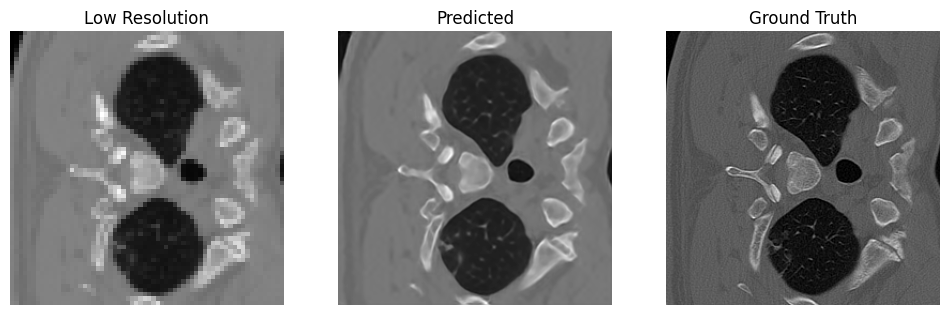

Average SSIM: 0.7289
Average PSNR: 29.3100
---------- /content/drive/MyDrive/TFM/modelos/model_EDSR.pth ----------
229


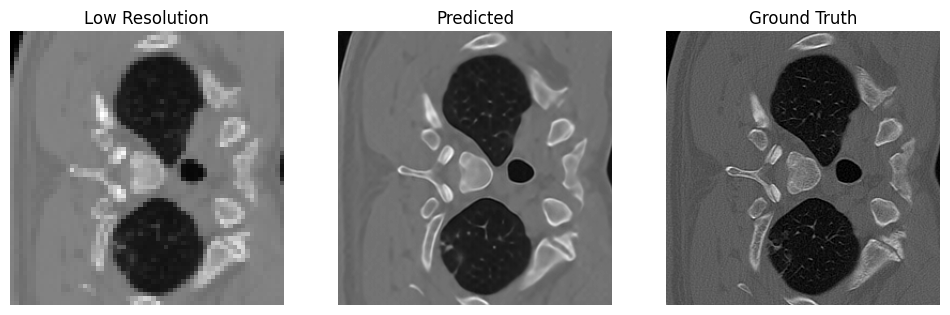

Average SSIM: 0.7546
Average PSNR: 30.3729
---------- /content/drive/MyDrive/TFM/modelos/model_SRResNet.pth ----------
229


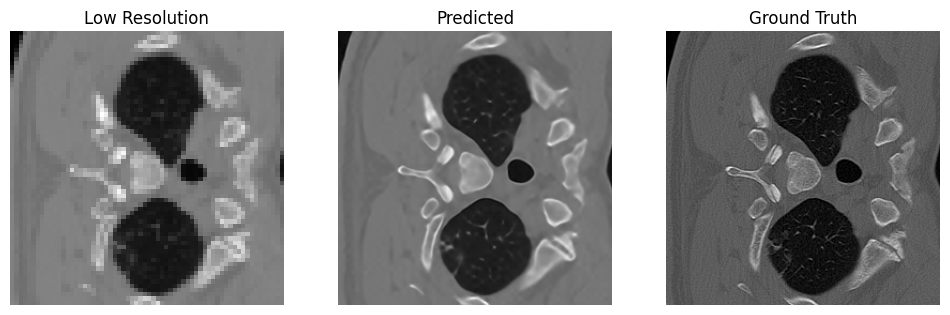

Average SSIM: 0.7503
Average PSNR: 30.2637
---------- /content/drive/MyDrive/TFM/modelos/model_RCAN.pth ----------
229


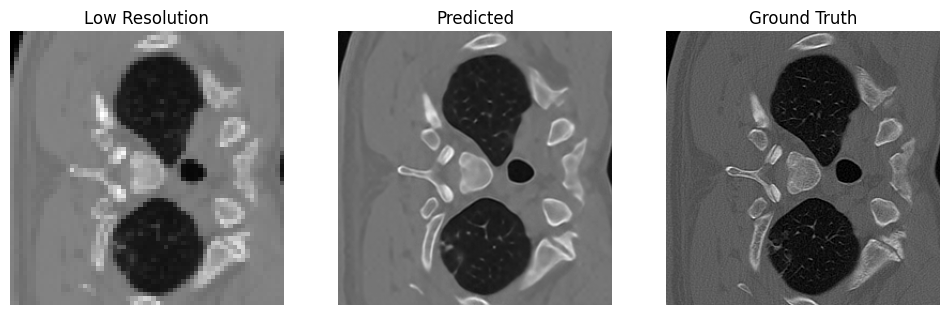

Average SSIM: 0.7555
Average PSNR: 30.4423
---------- /content/drive/MyDrive/TFM/modelos/model_SWINIR.pth ----------
229


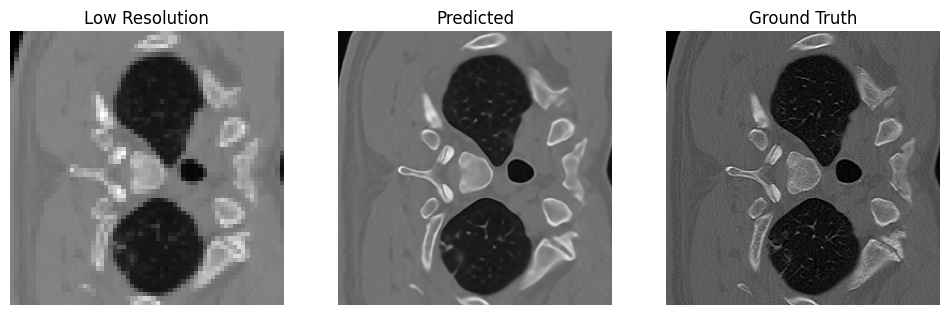

Average SSIM: 0.7626
Average PSNR: 30.6322
---------- /content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth ----------
229


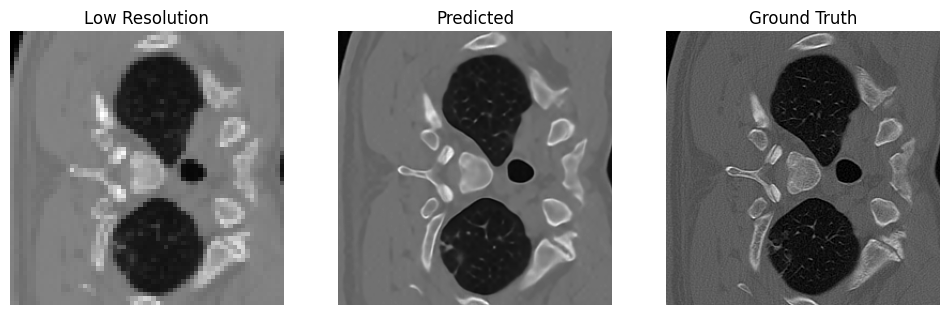

Average SSIM: 0.7595
Average PSNR: 30.4823


In [29]:
import random
random_index = random.randint(0, len(test_loader.dataset) - 1)
models_path=['/content/drive/MyDrive/TFM/modelos/model_SRCNN.pth',
 '/content/drive/MyDrive/TFM/modelos/model_EDSR.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SRResNet.pth',
 '/content/drive/MyDrive/TFM/modelos/model_RCAN.pth',
              '/content/drive/MyDrive/TFM/modelos/model_SWINIR.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth']
for i in models_path:
  print('-'*10,i,'-'*10)
  model_1=torch.load(i)
  test_model_and_plot_random(model_1.to('cuda'),test_loader,'cuda',229)

229


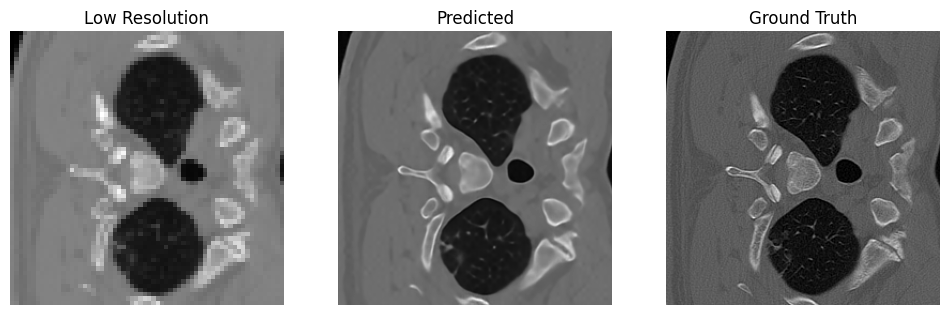

Average SSIM: 0.7616
Average PSNR: 30.5826


In [30]:
test_model_and_plot_random(model.to('cuda'),test_loader,'cuda',229)

In [31]:
import os
import torch
from matplotlib import pyplot as plt

def save_predictions_of_all_models_for_specific_index(model_paths, test_loader, device, save_dir='model_predictions', index=0):
    # Crear el directorio de guardado si no existe
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Cargar todos los modelos y ponerlos en modo de evaluación
    models = {path: torch.load(path, map_location=device).eval() for path in model_paths}

    # Acceder a la imagen de baja resolución especificada por el índice
    low_res, _ = test_loader.dataset[index]
    low_res = low_res.unsqueeze(0).to(device)  # Añadir dimensión de batch

    # Guardar la predicción de cada modelo para la imagen específica
    for path, model in models.items():
        with torch.no_grad():
            output = model(low_res)
            predicted = output.squeeze().cpu().numpy()

        # Guardar la predicción
        plt.imsave(os.path.join(save_dir, f"{os.path.basename(path)[:-3]}_prediction_{index}.png"), predicted, cmap='gray')

    # También guardar la imagen de alta resolución original (ground truth) para el índice especificado
    _, high_res = test_loader.dataset[index]
    high_res_np = high_res.squeeze().cpu().numpy()
    plt.imsave(os.path.join(save_dir, f"Ground_Truth_{index}.png"), high_res_np, cmap='gray')




random_index = 366
models_path=[
  '/content/drive/MyDrive/TFM/modelos/model_SRCNN.pth',
 '/content/drive/MyDrive/TFM/modelos/model_EDSR.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SRResNet.pth',
 '/content/drive/MyDrive/TFM/modelos/model_RCAN.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth']
save_predictions_of_all_models_for_specific_index(models_path, test_loader, 'cuda', save_dir='model_predictions_2', index=229)

In [32]:
def save_predictions_of_all_models_for_specific_index_1_model(model, test_loader, device, save_dir='model_predictions', index=0):
    # Crear el directorio de guardado si no existe
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Cargar todos los modelos y ponerlos en modo de evaluación

    # Acceder a la imagen de baja resolución especificada por el índice
    low_res, _ = test_loader.dataset[index]
    low_res = low_res.unsqueeze(0).to(device)  # Añadir dimensión de batch


    with torch.no_grad():
        output = model(low_res)
        predicted = output.squeeze().cpu().numpy()

    # Guardar la predicción
    plt.imsave(os.path.join(save_dir, f"{os.path.basename(path)[:-3]}_prediction_{index}.png"), predicted, cmap='gray')

    # También guardar la imagen de alta resolución original (ground truth) para el índice especificado
    _, high_res = test_loader.dataset[index]
    high_res_np = high_res.squeeze().cpu().numpy()
    plt.imsave(os.path.join(save_dir, f"Ground_Truth_{index}.png"), high_res_np, cmap='gray')
save_predictions_of_all_models_for_specific_index_1_model(model.to('cuda'), test_loader, 'cuda', save_dir='model_predictions_SR_V4_CT', index=229)

# INFERENCE

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=26b20540d25ab8ff9ee9ec52d5214f89793c7ea6bd4f5faa3508a3e2900232b7
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


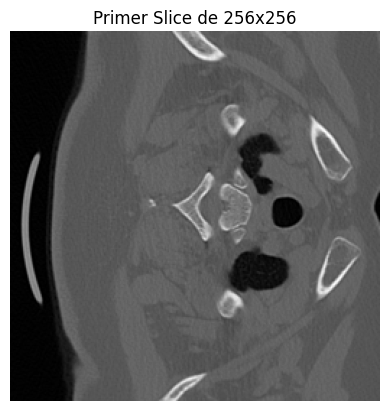

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(ref_ct_covid[251][0,:,:], cmap='gray')
plt.title('Primer Slice de 256x256')
plt.axis('off')  # Ocultar los ejes para enfocarse en la imagen
plt.show()

In [ ]:
archivos_model = []
path = '/content/drive/MyDrive/TFM/modelos'  # El directorio con los archivos .npy
# Recorrer cada archivo en el directorio
for archivo in os.listdir(path):

    # Verificar si el nombre del archivo comienza con 'model'
    if archivo.startswith('model'):
        archivos_model.append('/content/drive/MyDrive/TFM/modelos/'  +archivo)
# Mostrar la lista de archivos
print(archivos_model)

['/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V1.pth', '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V2.pth', '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V3.pth', '/content/drive/MyDrive/TFM/modelos/model_SRCNN.pth', '/content/drive/MyDrive/TFM/modelos/model_EDSR.pth', '/content/drive/MyDrive/TFM/modelos/model_SRResNet.pth', '/content/drive/MyDrive/TFM/modelos/model_RCAN.pth', '/content/drive/MyDrive/TFM/modelos/model_SWINIR.pth', '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth', '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4_weights.pth', '/content/drive/MyDrive/TFM/modelos/model_EDSR.pth_output_2.png', '/content/drive/MyDrive/TFM/modelos/model_SRResNet.pth_output_2.png', '/content/drive/MyDrive/TFM/modelos/model_RCAN.pth_output_2.png', '/content/drive/MyDrive/TFM/modelos/model_SWINIR.pth_output_2.png', '/content/drive/MyDrive/TFM/modelos/mod

# VISUALIZE


In [ ]:
models_path=[]
for model_path in archivos_model:
    if 'state' not in model_path:
        # Hacer algo con los archivos que contienen 'state'
        models_path.append(model_path)



/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V1 - Total Params: 936241, Average SSIM: 0.7523, Average PSNR: 30.2923, Average Inference Time: 0.0129 seconds/sample
/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V2 - Total Params: 1208235, Average SSIM: 0.7603, Average PSNR: 30.5936, Average Inference Time: 0.0143 seconds/sample
/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V3 - Total Params: 1208427, Average SSIM: 0.7545, Average PSNR: 30.3962, Average Inference Time: 0.0143 seconds/sample
/content/drive/MyDrive/TFM/modelos/model_SRCNN - Total Params: 8129, Average SSIM: 0.7304, Average PSNR: 29.4400, Average Inference Time: 0.0054 seconds/sample
/content/drive/MyDrive/TFM/modelos/model_EDSR - Total Params: 3002753, Average SSIM: 0.7548, Average PSNR: 30.4755, Average Inference Time: 0.0112 seconds/sample
/content/drive/MyDrive/TFM/modelos/model_SRResNet - Total Params: 935043, Average SSIM: 0.7497, Average PS

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

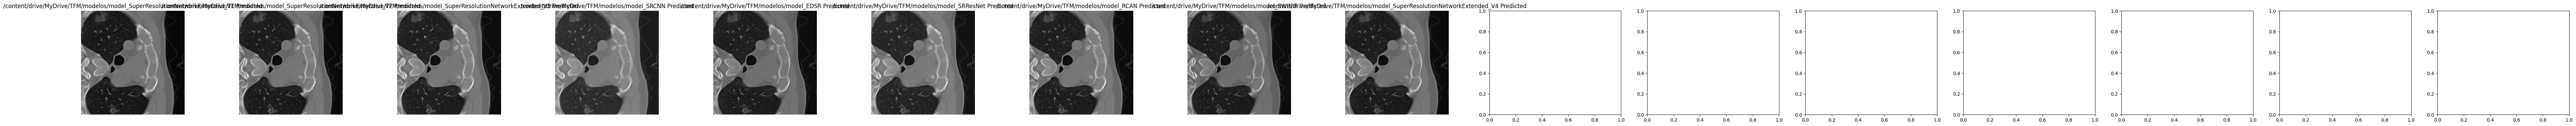

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def test_models_and_plot(model_paths, test_loader, device):
    num_models = len(model_paths)
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    fig, axs = plt.subplots(1, num_models + 1, figsize=(6 * (num_models + 1), 4))

    for model_idx, model_path in enumerate(model_paths):

        model = torch.load(model_path)  # Asumiendo que el path incluye el nombre completo
        model.to(device)
        model.eval()

        # Calcular el número total de parámetros
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        ssim_total = 0
        psnr_total = 0
        num_samples = 0
        random_image_selected = False
        start_time = time.time()  # Inicio del conteo de tiempo

        with torch.no_grad():
            for i, (low_res, high_res) in enumerate(test_loader):
                low_res = low_res.to(device)
                high_res = high_res.to(device)
                outputs = model(low_res)

                for j in range(outputs.size(0)):
                    predicted = outputs[j].squeeze().cpu().numpy()
                    original = high_res[j].squeeze().cpu().numpy()

                    ssim_total += ssim(original, predicted, data_range=predicted.max() - predicted.min())
                    psnr_total += psnr(original, predicted, data_range=predicted.max() - predicted.min())

                    if i * test_loader.batch_size + j == random_index:
                        axs[model_idx].imshow(predicted, cmap='gray')
                        axs[model_idx].set_title(f"{model_path[:-4]} Predicted")
                        axs[model_idx].axis('off')

                        if model_idx == num_models - 1:
                            axs[num_models].imshow(original, cmap='gray')
                            axs[num_models].set_title("Ground Truth")
                            axs[num_models].axis('off')

                        random_image_selected = True

                num_samples += outputs.size(0)
                if random_image_selected:
                    break
        end_time = time.time()  # Fin del conteo de tiempo

        inference_time = end_time - start_time
        avg_inference_time = inference_time / num_samples
        avg_ssim = ssim_total / num_samples
        avg_psnr = psnr_total / num_samples



        print(f"{model_path[:-4]} - Total Params: {total_params}, Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.4f}, Average Inference Time: {avg_inference_time:.4f} seconds/sample")

    plt.tight_layout()
    plt.show()

test_models_and_plot(models_path, test_loader, 'cuda')

In [ ]:
import os
import matplotlib.pyplot as plt

def test_models_and_save_individual_images(model_paths, test_loader, device, save_dir='saved_images'):
    num_models = len(model_paths)
    random_index = random.randint(0, len(test_loader.dataset) - 1)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Crea el directorio si no existe

    for model_idx, model_path in enumerate(model_paths):
        model = torch.load(model_path, map_location=device)  # Asegúrate de que el modelo se carga en el dispositivo adecuado
        model.eval()
        print(model_idx)
        with torch.no_grad():
            for i, (low_res, high_res) in enumerate(test_loader):
                if i * test_loader.batch_size > random_index:
                    low_res = low_res.to(device)
                    high_res = high_res.to(device)
                    outputs = model(low_res)
                    j = random_index % test_loader.batch_size  # Calcula el índice específico dentro del batch
                    predicted = outputs[j].squeeze().cpu().numpy()
                    original = high_res[j].squeeze().cpu().numpy()
                    # Guardar la imagen predicha
                    plt.imsave(os.path.join(save_dir, f"{model_path[:-4]}_predicted_{random_index}.png"), predicted, cmap='gray')

                    if model_idx == 0:  # Solo guarda la verdad de fondo una vez
                        plt.imsave(os.path.join(save_dir, f"Ground_Truth_{random_index}.png"), original, cmap='gray')
                    break


test_models_and_save_individual_images(models_path, test_loader, 'cuda')


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

archivos_model = []
path = '/content/drive/MyDrive/TFM/modelos'  # El directorio con los archivos .npy
# Recorrer cada archivo en el directorio
for archivo in os.listdir(path):

    # Verificar si el nombre del archivo comienza con 'model'
    if archivo.startswith('model'):
        archivos_model.append('/content/drive/MyDrive/TFM/modelos/'  +archivo)
# Mostrar la lista de archivos
print(archivos_model)
models_path=[
#  '/content/drive/MyDrive/TFM/modelos/model_SRCNN.pth',
 '/content/drive/MyDrive/TFM/modelos/model_EDSR.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SRResNet.pth',
 '/content/drive/MyDrive/TFM/modelos/model_RCAN.pth',
              '/content/drive/MyDrive/TFM/modelos/model_SWINIR.pth',
 '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth']
def save_predictions_of_all_models_for_best_diff_image(model_paths, test_loader, device, specific_model_path, save_dir='best_model_difference_2', data_range=1):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Cargar todos los modelos
    models = {path: torch.load(path, map_location=device).eval() for path in model_paths}

    # Inicializar registros para las métricas
    metrics = {path: {'psnr': [], 'ssim': []} for path in model_paths}

    # Evaluar todas las imágenes con todos los modelos
    for i, (low_res, high_res) in enumerate(test_loader):
        low_res, high_res = low_res.to(device), high_res.to(device)
        for path, model in models.items():
            with torch.no_grad():
                output = model(low_res)
                for j in range(output.size(0)):
                    output_np = output[j].squeeze().cpu().numpy()
                    high_np = high_res[j].squeeze().cpu().numpy()
                    metrics[path]['psnr'].append(compare_psnr(high_np, output_np, data_range=data_range))
                    metrics[path]['ssim'].append(compare_ssim(high_np, output_np, data_range=data_range))

    # Calcular la diferencia de PSNR entre el modelo específico y el promedio de los otros para cada imagen
    differences = np.zeros(len(test_loader.dataset))
    for i in range(len(test_loader.dataset)):
        specific_psnr = np.array(metrics[specific_model_path]['psnr'])
        other_psnrs = np.array([metrics[path]['psnr'][i] for path in model_paths if path != specific_model_path])
        differences[i] = specific_psnr[i] - np.mean(other_psnrs)

    # Identificar la imagen con la mayor diferencia a favor del modelo específico
    best_index = np.argmax(differences)

    # Guardar la predicción de cada modelo para la imagen con la mayor diferencia
    for path, model in models.items():
        low_res, _ = test_loader.dataset[best_index]
        low_res = low_res.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(low_res)
            predicted = output.squeeze().cpu().numpy()

        # Guardar la predicción
        plt.imsave(os.path.join(save_dir, f"{os.path.basename(path)[:-3]}_prediction_for_best_diff_image_{best_index}.png"), predicted, cmap='gray')

    # También guardar la imagen original de alta resolución (ground truth)
    _, high_res = test_loader.dataset[best_index]
    high_res_np = high_res.squeeze().cpu().numpy()
    plt.imsave(os.path.join(save_dir, f"Ground_Truth_for_best_diff_image_{best_index}.png"), high_res_np, cmap='gray')

# Ejemplo de uso:
save_predictions_of_all_models_for_best_diff_image(models_path, val_loader, 'cuda', specific_model_path= '/content/drive/MyDrive/TFM/modelos/model_SuperResolutionNetworkExtended_V4.pth')


In [ ]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_images_from_loader(model, test_loader,ct_ref ,device):
    # Asegúrate de que el modelo esté en modo evaluación y en el dispositivo correcto.
    model.eval()
    model.to(device)

    fig, ax = plt.subplots(16, 3, figsize=(10, 20))

    # Obtén un batch de imágenes del test_loader
    for i, (images, _) in enumerate(test_loader):
        if i == 0:  # Solo necesitamos el primer batch
            images = images.to(device)
            # Suponiendo que el modelo devuelve directamente la imagen superresolucionada
            images=images[:20]
            ct_ref_downsampled=F.interpolate(ct_ref,
                                                scale_factor=1/4,
                                                mode='bilinear',
                                                align_corners=False).to(device)
            # Calcula el MSE en batch
            mse_values = batch_mse_loss(images,ct_ref_downsampled)
            psnr_values = batch_psnr(mse_values, data_range=1.0)  # Ajusta data_range según tus datos

            # Identifica las imágenes más similares basadas en el mayor PSNR
            most_similar_indices = psnr_values.argmax(dim=1)
            selected_images = ct_ref[most_similar_indices.to('cpu')]
            selected_images_lr = ct_ref_downsampled[most_similar_indices.to('cpu')]


            for idx in range(16):
                # Plotea la imagen original/superresolucionada
                ax[idx, 0].imshow(images[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[idx, 0].set_title(f'Output Image')
                ax[idx, 0].axis('off')

                # Plotea la imagen de referencia
                ax[idx, 1].imshow(selected_images_lr[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[idx, 1].set_title(f'Reference Image lr')
                ax[idx, 1].axis('off')
                ax[idx, 2].imshow(selected_images[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[idx, 2].set_title(f'Reference Image ')
                ax[idx, 2].axis('off')

            break  # Ya hemos ploteado las primeras 4 imágenes, salimos del loop

    plt.show()

# Llama a la función con tu modelo, test_loader y el dispositivo adecuado ('cuda' o 'cpu')
plot_images_from_loader(model, test_loader,ref_ct, 'cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

def save_images_from_loader(model, test_loader, ct_ref, device, output_dir='output_images'):
    # Asegúrate de que el modelo esté en modo evaluación y en el dispositivo correcto.
    model.eval()
    model.to(device)

    # Crea el directorio de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Procesa el primer batch de imágenes del test_loader
    for i, (images, _) in enumerate(test_loader):
        if i == 0:  # Solo procesamos el primer batch
            images = images.to(device)[:16]  # Ajusta aquí para cambiar el número de imágenes
            ct_ref_downsampled = F.interpolate(ct_ref, scale_factor=1/4, mode='bilinear', align_corners=False).to(device)

            # Calcula el MSE y el PSNR en batch
            mse_values = batch_mse_loss(images, ct_ref_downsampled)
            psnr_values = batch_psnr(mse_values, data_range=1.0)

            # Identifica las imágenes más similares
            most_similar_indices = psnr_values.argmax(dim=1)
            selected_images = ct_ref[most_similar_indices.to('cpu')]
            selected_images_lr = ct_ref_downsampled[most_similar_indices.to('cpu')]

            for idx in range(16):
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))

                # Imagen procesada
                ax[0].imshow(images[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[0].set_title('Input Image')
                ax[0].axis('off')

                # Imagen de referencia de baja resolución
                ax[1].imshow(selected_images_lr[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[1].set_title('Reference Image LR')
                ax[1].axis('off')

                # Imagen de referencia
                ax[2].imshow(selected_images[idx].squeeze().cpu().numpy(), cmap='gray')
                ax[2].set_title('Reference Image')
                ax[2].axis('off')

                # Guarda cada conjunto de imágenes
                plt.savefig(os.path.join(output_dir, f'image_set_{idx+1}.png'))
                plt.close()  # Cierra la figura actual para liberar memoria

            break  # Finaliza después de procesar el primer batch

# Ejemplo de uso de la función
# Asegúrate de definir test_loader, ct_ref, y 'cuda' o 'cpu' según tu configuración
save_images_from_loader(model, test_loader, ref_ct, 'cuda', '/content/drive/MyDrive/TFM/image_examples')
